In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/D325_FinalPro/ieee-fraud-detection/"
%pwd
%ls

/content/drive/MyDrive/D325_FinalPro/ieee-fraud-detection
data_final.csv  fraud_net.h5           test_identity.csv     train_identity.csv
dat.zip         sample_submission.csv  test_transaction.csv  train_transaction.csv


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline



#1: Dataset Loading

In [ ]:
data = "./"
train_iden = data + "train_identity.csv"
test_iden = data + "test_identity.csv"
train_trans = data + "train_transaction.csv"
test_trans = data + "test_transaction.csv"
sample_sub = data + "sample_submission.csv"


In [ ]:
# Read the datasets and check the dimensions of the training dataset.
train_identity = pd.read_csv(train_iden)
test_identity = pd.read_csv(test_iden)
train_transaction = pd.read_csv(train_trans)
test_transaction = pd.read_csv(test_trans)

In [ ]:
print(f"Shape of transaction train data: {train_identity.shape}")
print(f"Shape of identity train data: {train_transaction.shape}")

Shape of transaction train data: (144233, 41)
Shape of identity train data: (590540, 394)


In [ ]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
total_transaction = len(train_transaction)
identity_trans_perc = np.sum(train_transaction["TransactionID"].isin(train_identity["TransactionID"].unique()))/total_transaction
print(f"Percentage of indentified transaction {np.round(identity_trans_perc * 100,2)}%")

Percentage of indentified transaction 24.42%


In [ ]:
# Combining the 2 dataset
df_train = train_transaction.merge(train_identity,on=['TransactionID'],how='left')


In [ ]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


#2. Exploratory Data Analysis (EDA)

##2.1 Target Variable (isFraud)

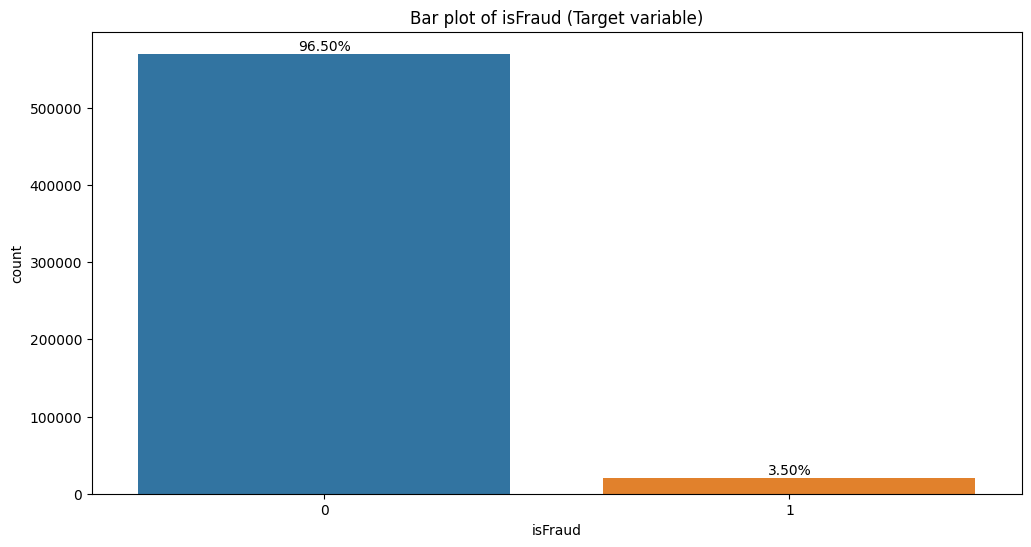


Number of observation in each category of isFraud: 

0    569877
1     20663
Name: isFraud, dtype: int64


In [ ]:
plt.figure(figsize=(12, 6))

# Create count plot
ax = sns.countplot(data=df_train, x='isFraud')
total = len(df_train['isFraud'])
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title('Bar plot of isFraud (Target variable)')
plt.show()

print("\nNumber of observation in each category of isFraud: \n")
print(df_train["isFraud"].value_counts())

As we can see above, we have the problem of imbalanced data, with 96.5% of Not fraud and only 3.5% were classified as Fraud in the training dataset.

##2.2 Transaction DT (timedelta from a given reference datetime)

In [ ]:
# Weekday Distribution
df_train['WeekDay'] = (df_train['TransactionDT']//(60*60*24)-1)%7
tmp = df_train[['isFraud','WeekDay']].groupby(by=['WeekDay']).mean().reset_index().rename(columns={'isFraud':'fraudPerc'})

tmp_count = df_train[['TransactionID','WeekDay']].groupby(by=['WeekDay']).count().reset_index().rename(columns={'TransactionID':'transCount'})
tmp = tmp.merge(tmp_count,on=['WeekDay'])

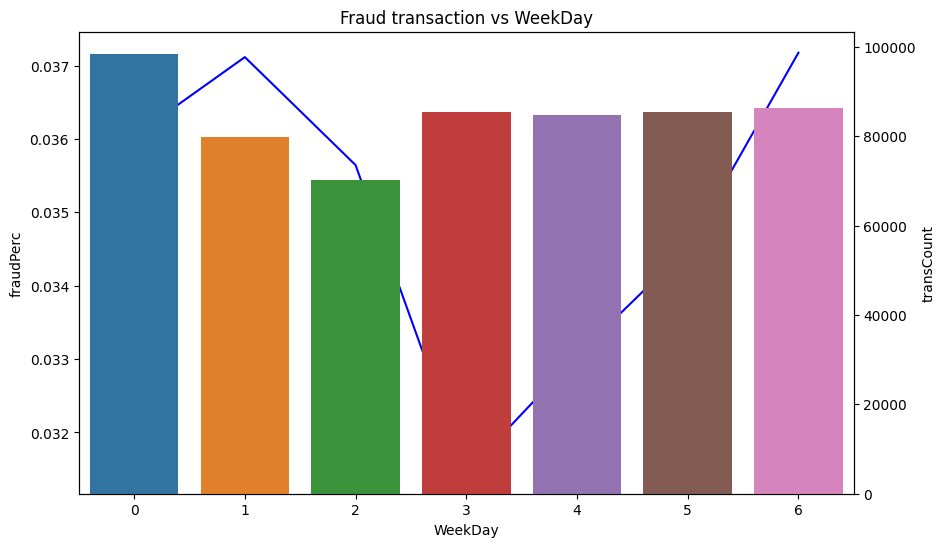

In [ ]:
fig, axes = plt.subplots(figsize=(10,6))
axes = sns.lineplot(x=tmp['WeekDay'],y=tmp['fraudPerc'],color='b')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['WeekDay'],y=tmp['transCount'])
axes.set_title('Fraud transaction vs WeekDay')
plt.show()

Based on the above plot, we can see that although we can observe a higher trend for Tuesday and Wednesday, however, there were not much differecens in terms of fraudelent rate throughout the day of week.

In [ ]:
df_train['HourDay'] = (df_train['TransactionDT']//(60*60))%24
tmp = df_train[['isFraud','HourDay']].groupby(by=['HourDay']).mean().reset_index().rename(columns={'isFraud':'fraudPerc'})

tmp_count = df_train[['TransactionID','HourDay']].groupby(by=['HourDay']).count().reset_index().rename(columns={'TransactionID':'transCount'})
tmp = tmp.merge(tmp_count,on=['HourDay'])

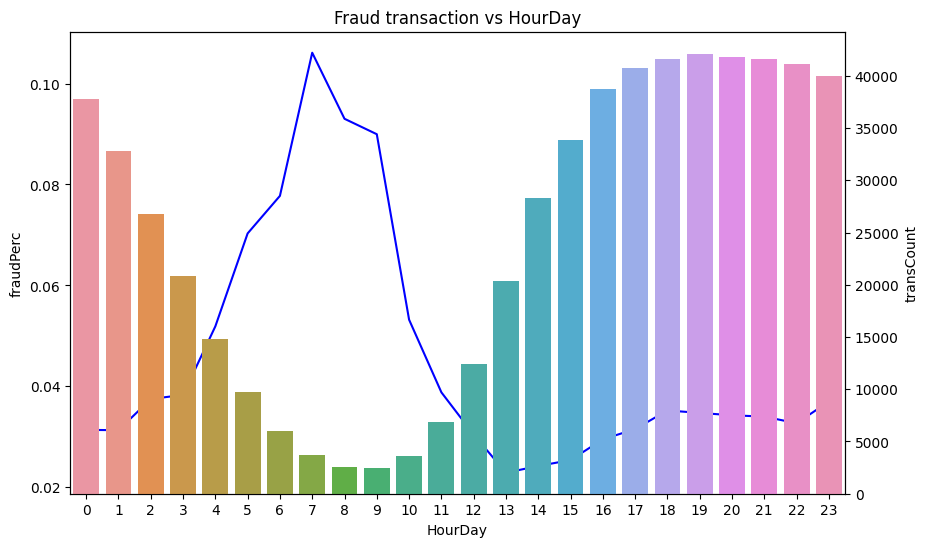

In [ ]:
fig, axes = plt.subplots(figsize=(10,6))
axes = sns.lineplot(x=tmp['HourDay'],y=tmp['fraudPerc'],color='b')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['HourDay'],y=tmp['transCount'])
axes.set_title('Fraud transaction vs HourDay')
plt.show()

Based on the above plot, we can see that we can divide further into sub categories in terms of percentage of fraudelent:


*   High time: 6AM to 9AM
*   Medium time: 3AM to 5AM, 10 to 11AM
*   Low time: 0-2AM, 12PM to 4PM



## 2.3 Transaction Amount

<Axes: xlabel='TransactionAmt', ylabel='Count'>

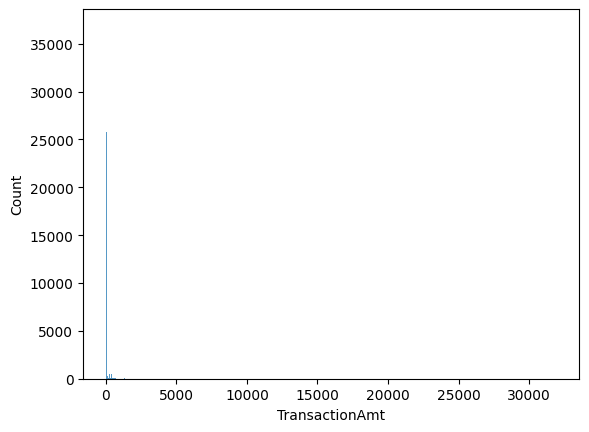

In [ ]:
sns.histplot(df_train, x="TransactionAmt")

In [ ]:
def transaction_decimal(amount):
    num = 0
    while((int(amount)*10 != int(amount*10)) and (num < 3)):
        num = num + 1
        amount = amount * 10
    return num

df_train["TransactionAmt_dec"] = df_train["TransactionAmt"].map(transaction_decimal)
print(df_train.head(n=10))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ...           id_34  id_35  id_36  id_37  \
0    NaN  150.0    discover  142.0  ...             NaN    NaN    NaN   

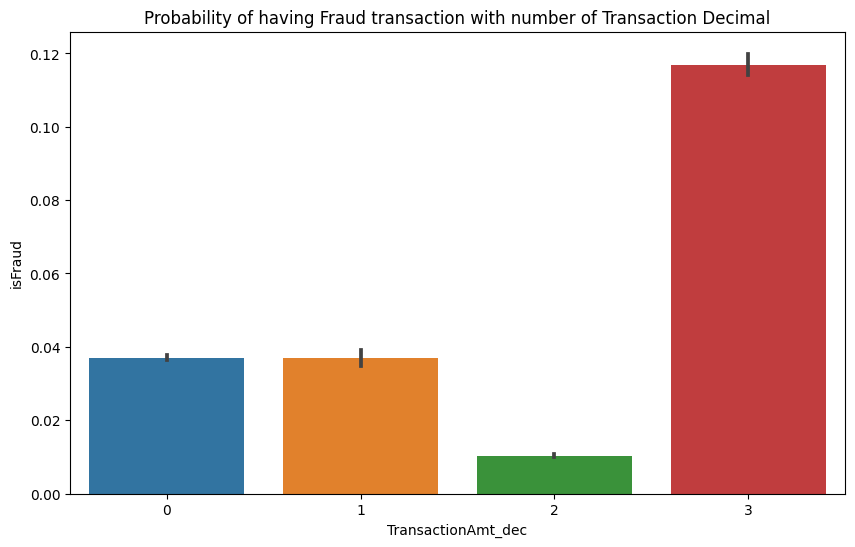

In [ ]:

fig, axes = plt.subplots(figsize=(10,6))
axes = sns.barplot(x=df_train['TransactionAmt_dec'],y=df_train['isFraud'])
axes.set_title('Probability of having Fraud transaction with number of Transaction Decimal')
plt.show()

In [ ]:
print('Mean transaction amt for fraud is {:.4f}'.format(df_train.loc[df_train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(df_train.loc[df_train['isFraud'] ==0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


Based on those transaction amount, it's quite hard to differentiate among those average in practical

## 2.4 Email Domain

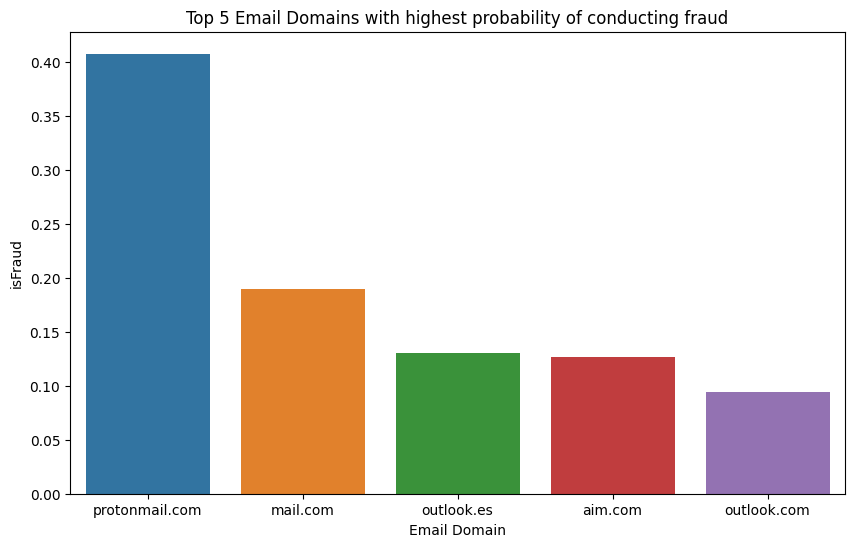

In [ ]:
email_tmp = df_train["isFraud"].eq(1).groupby(df_train["P_emaildomain"]).mean().reset_index()
temp = email_tmp.sort_values(by="isFraud", ascending=False).head()
fig, axes = plt.subplots(figsize=(10,6))
axes = sns.barplot(x=temp['P_emaildomain'],y=temp['isFraud'])
axes.set_title('Top 5 Email Domains with highest probability of conducting fraud')
axes.set_xlabel("Email Domain")
plt.show()

##2.5 ProductDC

In [ ]:
# Reference from: https://www.kaggle.com/code/deepakkaura/ieee-cis-a-story-of-fraud-detection#IEEE-CIS-:-A-story-of-Fraud-Detection
def hor_plot(feat,df=df_train,label_rotation=False,shape=(12,8)):

    val_cnts = df[feat].value_counts()
    df1 = pd.DataFrame({feat: val_cnts.index,'Number of units': val_cnts.values})
    # Calculate the percentage of target=1 per category value.For that what we did is we took the mean value of TARGET
    percent = df[[feat, 'isFraud']].groupby([feat],as_index=False).mean()
    percent.sort_values(by='isFraud', ascending=False, inplace=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=shape)
    s = sns.barplot(ax=ax1, x = feat, y="Number of units",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    s = sns.barplot(ax=ax2, x = feat, y='isFraud', order=percent[feat], data=percent)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    plt.ylabel('Percent of Fraud transactions [Target with value 1]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show();

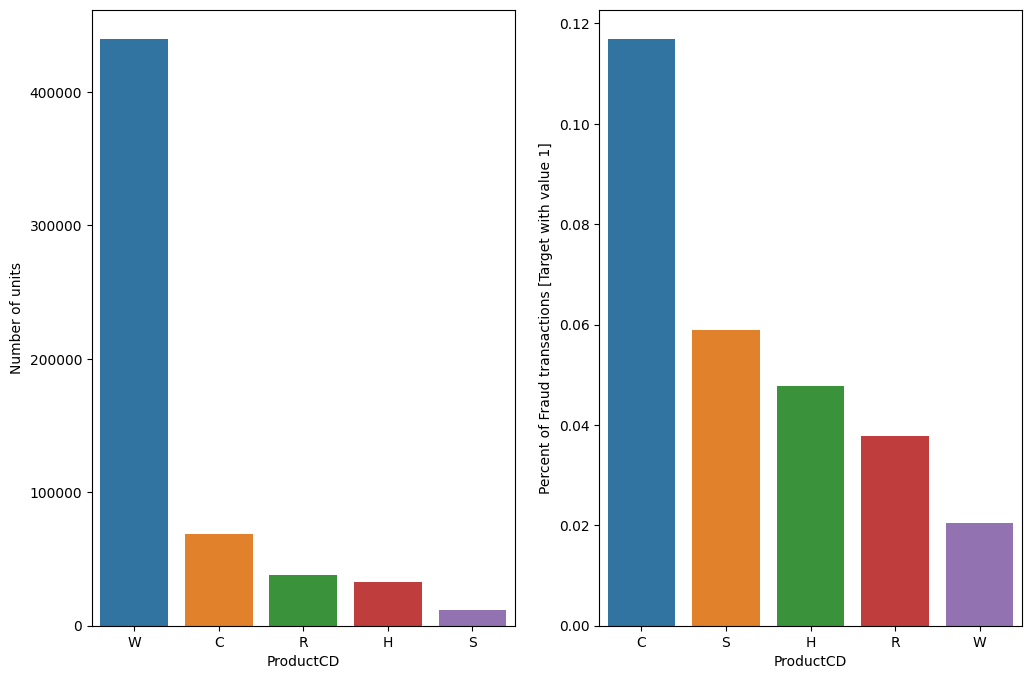

In [ ]:
hor_plot(df = df_train, feat = "ProductCD")

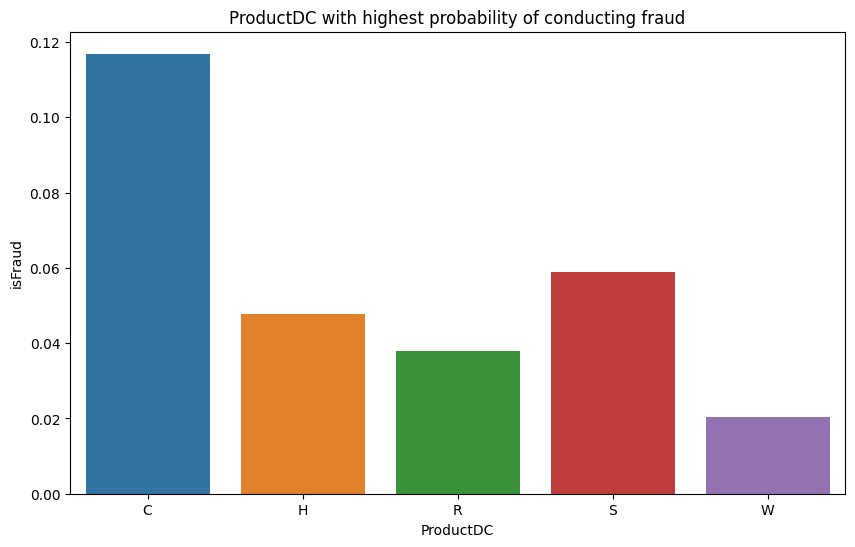

In [ ]:
product_tmp = df_train["isFraud"].eq(1).groupby(df_train["ProductCD"]).mean().reset_index()
fig, axes = plt.subplots(figsize=(10,6))
axes = sns.barplot(x=product_tmp['ProductCD'],y=product_tmp['isFraud'])
axes.set_title('ProductDC with highest probability of conducting fraud')
axes.set_xlabel("ProductDC")
plt.show()

## 2.6 Type of Cards

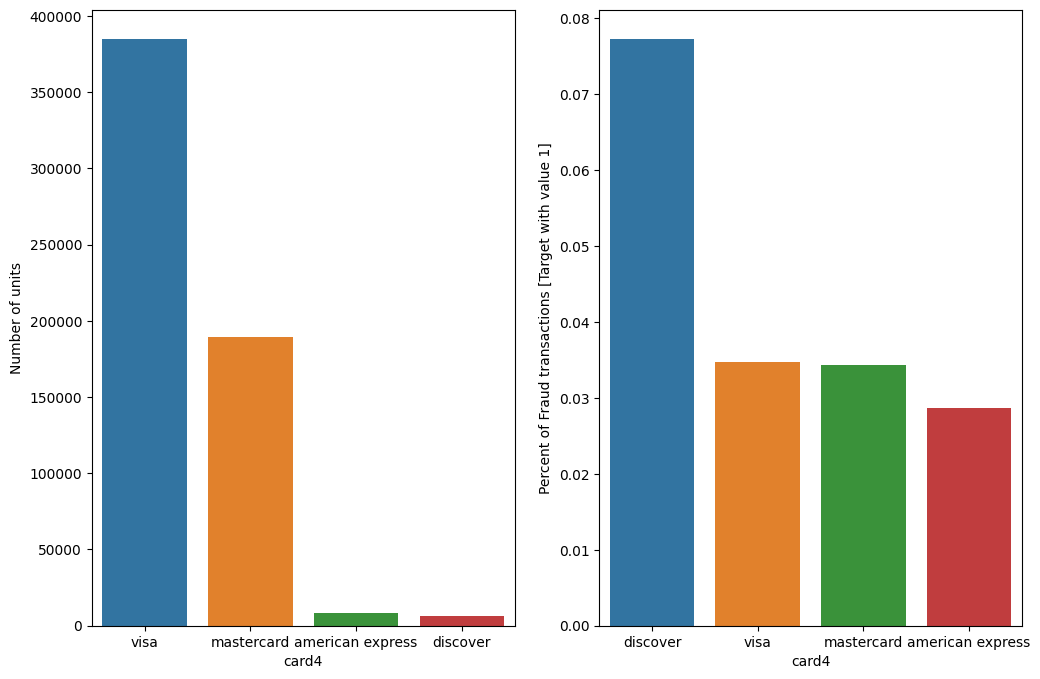

In [ ]:
hor_plot("card4")

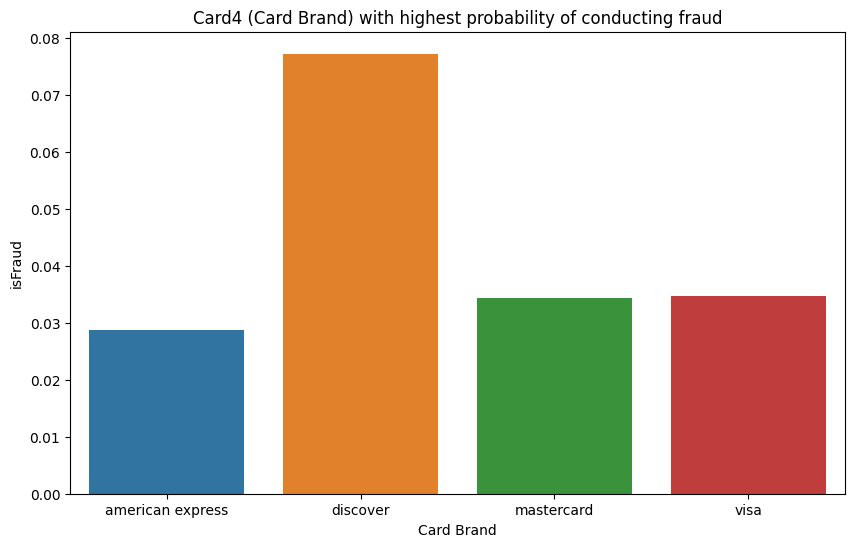

In [ ]:
card4_tmp = df_train["isFraud"].eq(1).groupby(df_train["card4"]).mean().reset_index()
fig, axes = plt.subplots(figsize=(10,6))
axes = sns.barplot(x=card4_tmp['card4'],y=card4_tmp['isFraud'])
axes.set_title('Card4 (Card Brand) with highest probability of conducting fraud')
axes.set_xlabel("Card Brand")
plt.show()

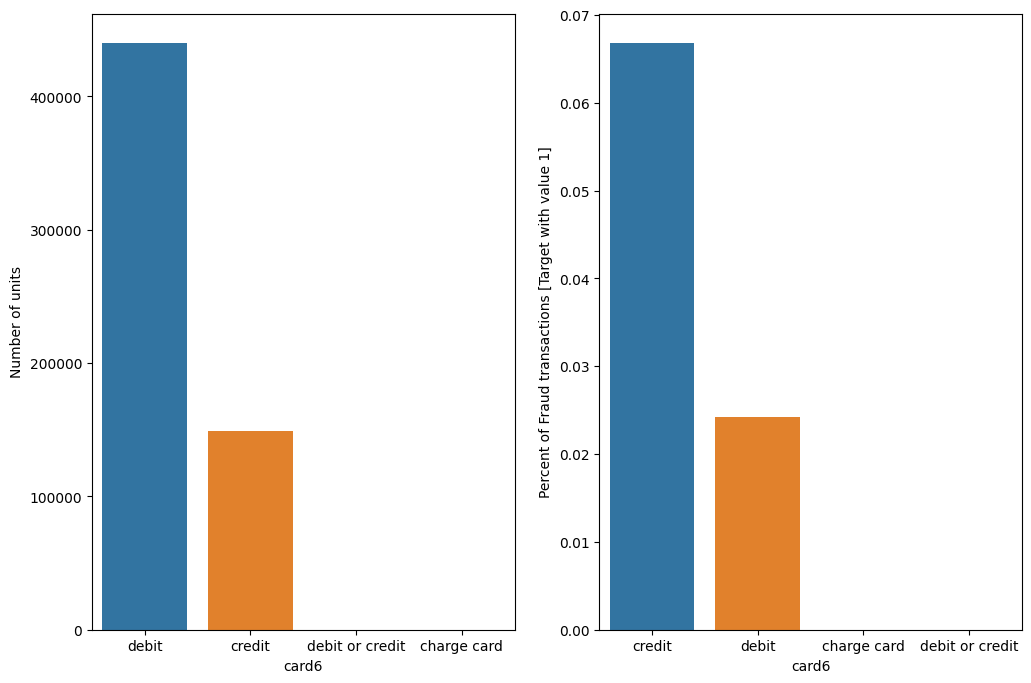

In [ ]:
hor_plot("card6")

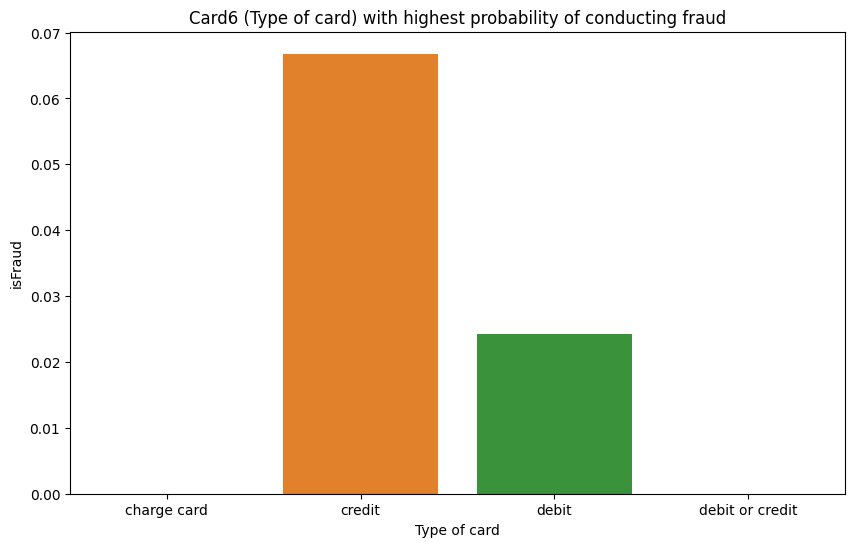

In [ ]:
card6_tmp = df_train["isFraud"].eq(1).groupby(df_train["card6"]).mean().reset_index()
fig, axes = plt.subplots(figsize=(10,6))
axes = sns.barplot(x=card6_tmp['card6'],y=card6_tmp['isFraud'])
axes.set_title('Card6 (Type of card) with highest probability of conducting fraud')
axes.set_xlabel("Type of card")
plt.show()

##2.7: Device Type and Info

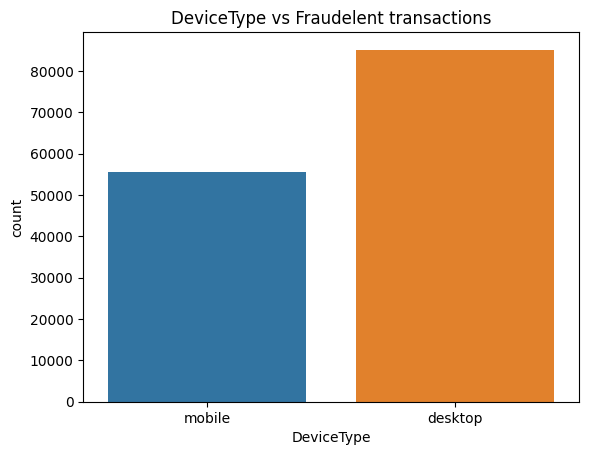

In [ ]:
ax = sns.countplot(x="DeviceType", data=df_train)
ax.set_title('DeviceType vs Fraudelent transactions')
plt.show()

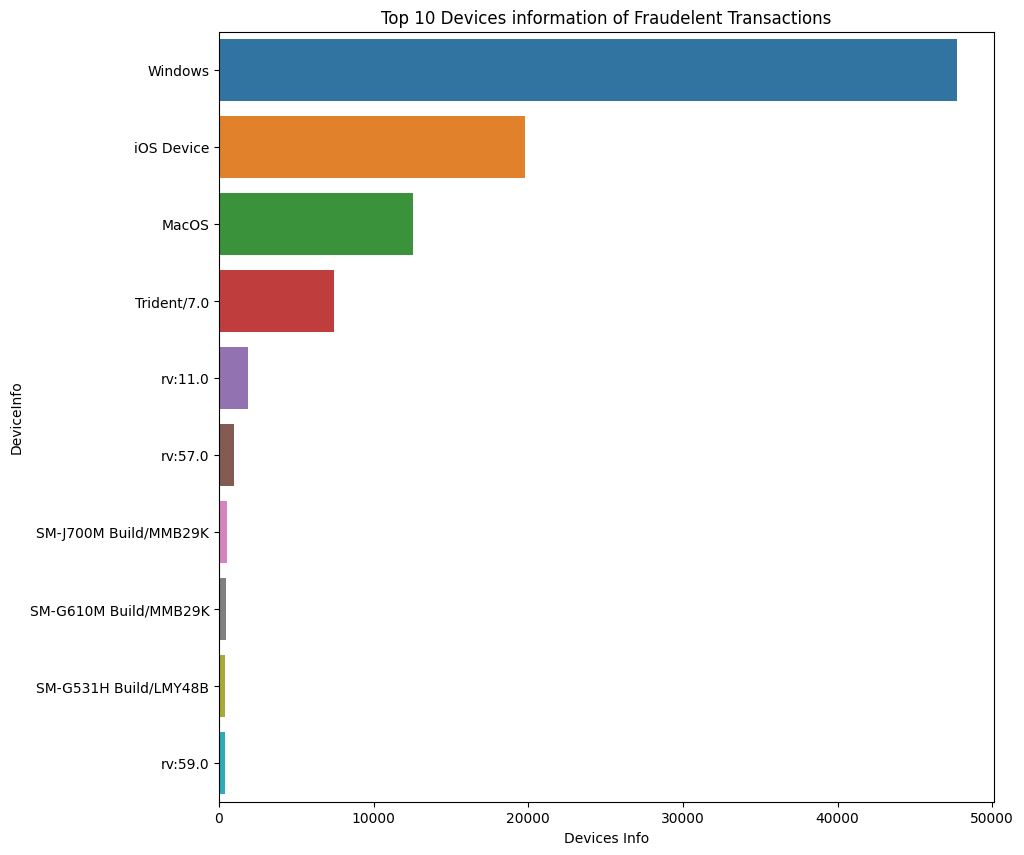

In [ ]:
device_info_tmp = df_train["isFraud"].eq(1).groupby(df_train["DeviceInfo"]).count().reset_index()
temp = device_info_tmp.sort_values(by="isFraud", ascending=False).head(10)
fig, axes = plt.subplots(figsize=(10,10))
axes = sns.barplot(y=temp['DeviceInfo'],x=temp['isFraud'])
axes.set_title('Top 10 Devices information of Fraudelent Transactions')
axes.set_xlabel("Devices Info")
plt.show()

#3. Model Building (in another notebook)